## Welcome to Algosoc, the soceity for algorithmic trading and quantitative finance at Imperial

### Who are we

We are founded in March 2018 with the aim to provide education and networking opportunities for students interested in algorithmic trading and quantitative finance. In 2018 and 2019 we organise the Algothon with Blackrock which is the flagship event of our soceity. Algothon 2020 was cancelled this year due to covid-19. Algothon 2021 was held online with Aspect Capital. 

http://www.algosoc.com/

#### Lecture 1: Understanding financial data

#### Price data


The most basic data to be dealt with in quantitative finance is price data, which represent how much a financial asset is worth at a given time. Traditionally (1990s), time series models such as ARIMA model are used widely in trading to capture trends in the market. Recently, the focus has moved to using deep learning models such as LSTM and CNN to learn more complicated behaviour.

https://reference.wolfram.com/language/ref/ARIMAProcess.html    
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM    

Price data is determined by two charactereistics, frequency of data and types of data. Frequency of data can ranged from microseconds data (tick level) to end-of-date data (daily resolution). We will focus on data that have a minute resoluion or above. Major types of data include bar data, trade data and quote data.

In an exchange, quote data (Orderbook) is displayed for a stock in real time which has the bid and ask price (with size) submitted by different market participants. A trade is made if someone is willing the buy the security at the ask price (or sell the security at the bid price). Bar data is then aggregrated using the trade price and volume over an interval, which usually is a minute, an hour and a day.

https://iextrading.com/apps/tops/

In this notebook, we will illustrate various basic concepts in finance using the most famous ETF, SPDR S&P 500 (SPY) which keep tracks of the most important stock market index S&P 500 in the world. This ETF invest in the 500 biggest stocks listed in the US, weighted by market-cap. 

In [2]:
! pip install yfinance

     |████████████████████████████████| 6.3 MB 6.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=707d41390f449531fdfe897fb0be8c7a2a3cdc31da552a8c0c421acecac7687e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd

In [4]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")

A typical bar data would include Open, High, Low, Close and Volume within a time period, which is a trading day in the following example. As stocks can pay dividend and have splits, we usually use adjusted price to perform statistical analysis. From the adjusted price, we can derive the total return of the stock (which is the sum of price return and dividends, reinvested). 



In [5]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-07,438.390015,441.679993,438.200012,438.660004,72437500,0.0,0
2021-10-08,439.480011,439.890015,437.190002,437.859985,74492900,0.0,0
2021-10-11,437.160004,440.260010,434.619995,434.690002,65233300,0.0,0
2021-10-12,435.670013,436.100006,432.779999,433.619995,71078500,0.0,0
2021-10-13,434.709991,435.290009,431.540009,433.170013,22750297,0.0,0


Stock price are not stationary as they tend to grow over time. (Exception: Japanese stock market). 

For building models, it is better to use the log-return instead. Log-return is better than percentage return since it is additive over different time periods. 

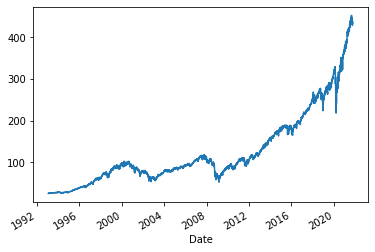

In [6]:
hist['Close'].plot()

In [7]:
## Calculating log-returns
hist['log_return'] = np.log(hist['Close']) - np.log(hist['Close'].shift(1))

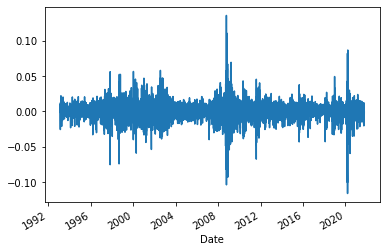

In [8]:
hist['log_return'].plot()

Statistical properties of stock market log-returns 

It has a positive mean, which is bigger than the average 10-year Treasury yield. This is called the risk premium of equity market

It has a negative skew, which demonstrates the fact the stock market experiences sharp drawdowns over a short period (2008,2020) 

It has a kurtosis greater than 3, suggesting it is more fat-tail than a normal distribution. 

The assumption of log-return following Gaussian distribution, as Brownian motion is the fundation of Black-Scholes Option pricing model. 

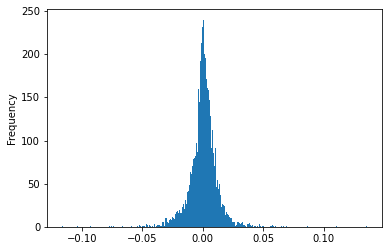

In [9]:
hist['log_return'].plot.hist(bins=500)

In [10]:
hist['log_return'].describe()

count    7229.000000
mean        0.000391
std         0.011821
min        -0.115887
25%        -0.004285
50%         0.000680
75%         0.005860
max         0.135577
Name: log_return, dtype: float64

In [11]:
hist['log_return'].skew()

-0.29985156436970767

In [12]:
hist['log_return'].kurtosis()

11.788815653462775

## Different measures of return 

We can separate the return of stock market into two parts. One as the close-to-open return (overnight return) and open-to-close return (intraday return) 

We can see intraday return has a mean close to zero, suggesting the mean-reversion nature of stock price during market hours. 

Most of the stock market return, for a buy-and-hold strategy in the long run, comes from holding stocks overnight. This can be considered as compensation of the risk to hold stocks overnight. 



In [13]:
hist['intraday_return'] = np.log(hist['Close']) - np.log(hist['Open'])
hist['overnight_return'] = np.log(hist['Open']) - np.log(hist['Close'].shift(1))

In [14]:
hist['intraday_return'].describe()

count    7230.000000
mean       -0.000007
std         0.009649
min        -0.094207
25%        -0.004141
50%         0.000427
75%         0.004580
max         0.088892
Name: intraday_return, dtype: float64

In [15]:
hist['overnight_return'].describe()

count    7229.000000
mean        0.000397
std         0.006727
min        -0.110357
25%        -0.002051
50%         0.000625
75%         0.003208
max         0.059519
Name: overnight_return, dtype: float64

### Volatility Scaling

We can measure the performance of a trading strategy by the sharpe ratio, which is ratio of excess return over to the volatility. 

Sharpe_Ratio = $\frac{r-r_f}{\sigma}$, where r is the return of the portfolio and $\sigma$ the standard deviation of the return of the portfolio. 

Volatility is detrimental to the long-term growth of capital as a strategy down 20% needs a 25% growth to recover. 

By adjusting our holdings of stock to constant volatility, so that we buy more during low volatility times and buy less during high volatility times. The Sharpe ratio can be improved compared to a constant buy-and-hold strategy.

Volatility plays an important role in portfolio construction and risk management. Risk parity, a famous hedge fund strategy aims to hold constant volatility exposure to different assets in the portfolio, rather than equal weighted. Banks are required to report their inventory risk at the end of time using VaR (Value at Risk) measures. 



In [16]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

In [17]:
# Weight portfolio by comparing the current 3-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

In [18]:
hist['return'].mean() / hist['return'].std()

0.03898980199477907

In [19]:
## Improvement of Sharpe ratio of constant vol strategy 
hist['vol_adj_return'].mean() / hist['vol_adj_return'].std()

0.0539259746778392

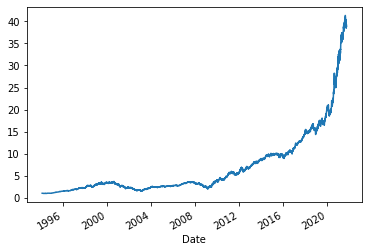

In [20]:
(1+hist['vol_adj_return']).cumprod().plot()

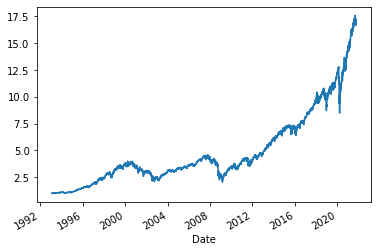

In [21]:
(1+hist['return']).cumprod().plot()

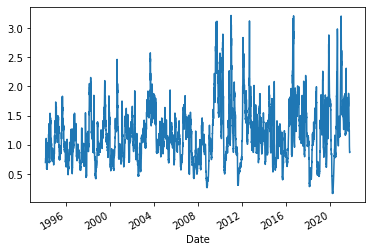

In [22]:
hist['vol_port_size'].plot()

To carry out the above volatility adjusted strategy, you need to have access to leverage (up to 3x). 

In [23]:
selected_etf = yf.Ticker("EEM")
hist = selected_etf.history(period="max")

In [24]:
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

# Weight portfolio by comparing the current 3-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

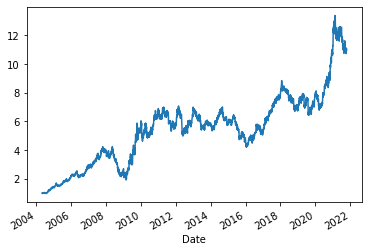

In [25]:
(1+hist['vol_adj_return']).cumprod().plot()

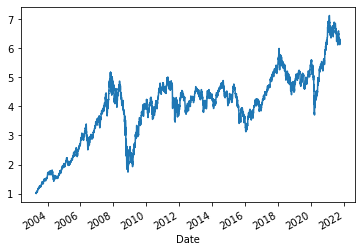

In [26]:
(1+hist['return']).cumprod().plot()

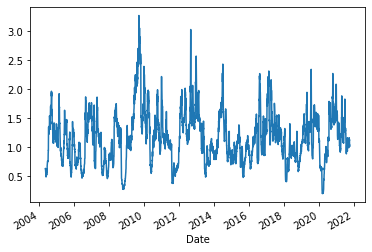

In [27]:
hist['vol_port_size'].plot()

The above strategy also applies to EM stock market. As long as the ETF will generate positive return in the long run, volatility scaling can improve sharpe ratio and return of strategy. 


## Recommended readings 

- Algorithmic Trading: Winning Strategies and Their Rationale, Ernest P. Chan

- Advances in Financial Machine Learning, Marcos López de Prado

- A Complete Guide to the Futures Market: Technical Analysis, Trading Systems, Fundamental Analysis, Options, Spreads, and Trading Principles (Wiley Trading), Jack D. Schwager

## Lecture 2 Volatility 

Volatility in portfolio is undesirable since they erode long term return of the portfolio. Investors are looking for ways to reduce portfolio volatility. For asset managers, holding government bonds and derivatives are common means to hedge against equity holdings they have.

Without formally introducing the concept of options (where we might do in later lectures), we will introduce the concept of a put option as an insurance policy. From this perspective, asset managers might buy put options (in reality put spreads or other more sophiscated strategies) to reduce drawdown in portfolio during market distress. 

The benefit of reducing drawdown and thus volatility in portfolio is that it allows rebalancing after market crash. Investors can sell their bonds or put options to buy cheap stocks. 

In this lecture, we will show that the buy-and-hold strategy is inherent a short volatility strategy, which means it benefits when market volatility is falling.  


In [28]:
## VIX index, the fear gauge of the global equity market 
selected_etf = yf.Ticker("^VIX")

In [29]:
vixhist = selected_etf.history(period="max")

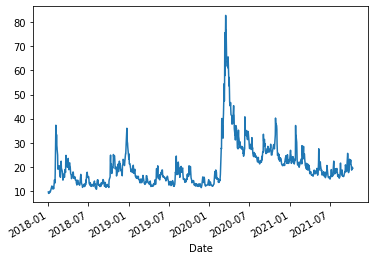

In [30]:
vixhist['Close'].loc['2018-01-01':].plot()

It is not possible to invest in VIX directly. There are volatility ETFs which keep tracks of the VIX Futures, where traders buy and sell to express their views on market volatility. VXX is an example of volatility ETF that are widely traded by retail.  

Due to rollover costs, VXX will generate a much worse return than VIX.


A crucial feature is that holding VIX futures, and similarly buying Put Options on SPY generates a negative return in the long run.

Considering the correlation between VXX (Long volatility) and SH (Short SPY) we conclude the long volatility strategies are inherently shorting the market. 

Assuming we can short VXX (that is short volatility) without additional borrowing cost, it will have a high correlation with the market return (long SPY). This is why we call buy-and-hold equity as inherenetly a short volatility strategy. 

Since buy-and-hold VXX will simply cancels the return from holding SPY, therefore VXX alone is not a good portfolio hedge. 




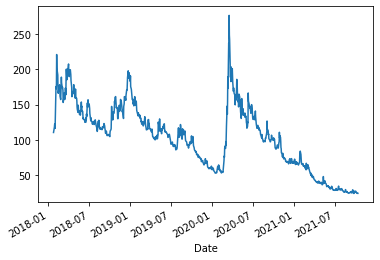

In [31]:
selected_etf = yf.Ticker("VXX")
vxxhist = selected_etf.history(period="max")
vxxhist['Close'].loc['2018-01-01':].plot()

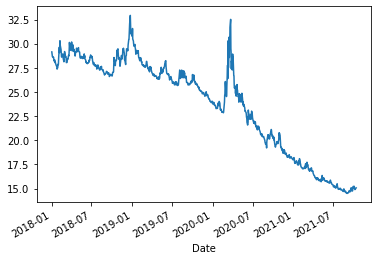

In [32]:
selected_etf = yf.Ticker("SH")
shhist = selected_etf.history(period="max")
shhist['Close'].loc['2018-01-01':].plot()

In [33]:
## Very high correlation between long volatility (UVXY) and short equity (SH) 
np.corrcoef(shhist['Close'].loc['2020-01-01':],vxxhist['Close'].loc['2020-01-01':])[0,1]

0.865106130261294

There are more than one kind of volatility ETFs

VXX keep track of the S&P 500 VIX Short-Term Futures Index Total Return
VXZ keep track of S&P 500 VIX Mid-Term Futures Index.

VXZ has a less significant contango effect than VXX, but keep track of the spot VIX less well. 

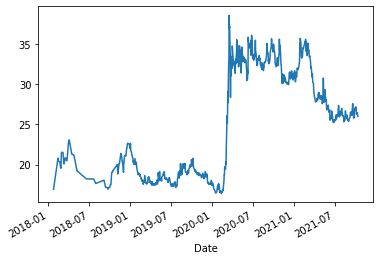

In [34]:
selected_etf = yf.Ticker("VXZ")
vxzhist = selected_etf.history(period="max")
vxzhist['Close'].loc['2018-01-01':].plot()

We will provide a very simple example of market regime model using Hidden Markov Model

In [35]:
! pip install yfinance
! pip install hmmlearn

     |████████████████████████████████| 374 kB 5.1 MB/s 


In [36]:
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import numpy as np

selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")
spyhist['Return'] = spyhist['Open'].pct_change()
trainrets = spyhist.loc['1996-01-01':'2017-01-01']
testrets = spyhist.loc['2018-01-01':'2022-02-25']

In [37]:
hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].values.reshape(-1, 1))


In [38]:

testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


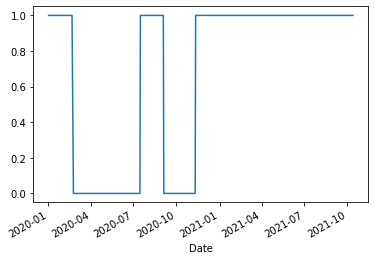

In [39]:
testrets['State'].loc['2020-01-01':].plot()

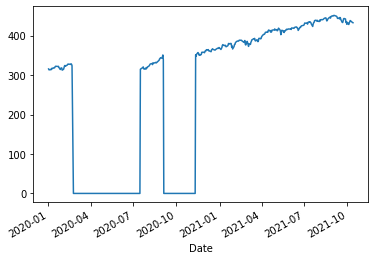

In [40]:
testrets['Filtered'].loc['2020-01-01':].plot()

In [41]:
## State 0 is bear market  
## State 1 is bull market 
testrets.groupby('State').mean()['Return']

State
0   -0.000540
1    0.000998
Name: Return, dtype: float64

In [42]:
testrets.groupby('State').std()['Return']

State
0    0.021660
1    0.007299
Name: Return, dtype: float64

Can we obtain a similar model by cosidering the value of VIX? 

In [43]:
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
selected_etf = yf.Ticker("^VIX")
vixhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
spyhist['Return'] = spyhist['Close'].pct_change()
spyhist['VIX'] = vixhist['Close']
spyhist['VIX_State'] = np.where(spyhist['VIX']<25,1,0)
trainrets = spyhist.loc['1996-01-01':'2015-01-01']
testrets = spyhist.loc['2018-01-01':'2022-01-01']

In [44]:
testrets.groupby('VIX_State').mean()['Return']

VIX_State
0   -0.001212
1    0.001125
Name: Return, dtype: float64

In [45]:
testrets.groupby('VIX_State').std()['Return']

VIX_State
0    0.025344
1    0.007956
Name: Return, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


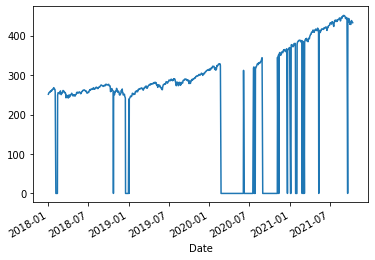

In [46]:
testrets['Filtered'] = testrets['Close'] * testrets['VIX_State']
testrets['Filtered'].loc['2018-01-01':].plot()

Splitting the test period by the value of VIX provides a similar model as HMM.


How about changing the number of of hidden states in HMM model 

In [47]:
hmm_model = GaussianHMM(
        n_components=3, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].dropna().values.reshape(-1, 1))


In [48]:
testrets = spyhist.loc['2018-01-01':'2021-12-25']
testrets['Shifted_Return'] = testrets['Return'].shift(-1)
testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

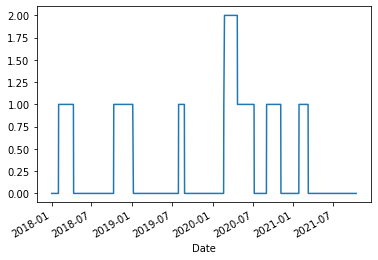

In [49]:
testrets['State'].plot()

In [50]:
testrets.groupby('State').mean()['Shifted_Return'] * np.sqrt(252)

State
0    0.017817
1   -0.000873
2   -0.036518
Name: Shifted_Return, dtype: float64

In [51]:
testrets.groupby('State').std()['Shifted_Return']

State
0    0.006753
1    0.014854
2    0.044910
Name: Shifted_Return, dtype: float64

In [52]:
testrets.groupby('State').count()['Return']

State
0    659
1    252
2     42
Name: Return, dtype: int64

In [53]:
testrets[testrets['State'].isin([2])].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,VIX,VIX_State,Shifted_Return,State,Filtered
Date,,,,,,,,,,,,,
2020-04-16,272.973625,273.834160,269.658647,272.924744,131798300,0.0,0,0.004824,40.110001,0,0.027015,2,545.849487
2020-04-17,279.065721,280.943222,276.151645,280.297852,146684800,0.0,0,0.027015,38.150002,0,-0.017618,2,560.595703
2020-04-20,276.356979,280.444515,275.124878,275.359558,100109300,0.0,0,-0.017618,43.830002,0,-0.030363,2,550.719116
2020-04-21,270.607137,271.888150,266.001329,266.998779,126385700,0.0,0,-0.030363,45.410000,0,0.022195,2,533.997559
2020-04-22,272.191338,274.782699,270.783196,272.924744,92951600,0.0,0,0.022195,41.980000,0,-0.000072,2,545.849487


In the following lectures we will introduce different strategy that aims to reduce portfolio drawdown during market drawdowns 


- Risk Parity (Leveraged bets on interest rates going down)
- Commodities Trend Following (Uncorrelated return during demand and supply shocks)
- Active Long Volatility (Time when to buy call/put options)


### Recommended Readings

- Market Regime Identification Using Hidden Markov Models https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3406068

- Regime-Switching Factor Investing with Hidden Markov Models 
https://www.mdpi.com/1911-8074/13/12/311/htm
